In [60]:
import pandas as pd
import numpy as np

import pickle
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [2]:
close_returns_raw = pd.read_csv('dataset/close_returns.csv', index_col = 0, parse_dates = True)
high_prices_raw = pd.read_csv('dataset/high_prices.csv', index_col = 0, parse_dates = True)
low_prices_raw = pd.read_csv('dataset/low_prices.csv', index_col = 0, parse_dates = True)
volume_raw = pd.read_csv('dataset/volume.csv', index_col = 0, parse_dates = True)
signals_A_raw = pd.read_csv('dataset/signals_A.csv', index_col = 0, parse_dates = True)
signals_B_raw = pd.read_csv('dataset/signals_B.csv', index_col = 0, parse_dates = True)

In [3]:
close_returns_raw.head()

,A.0,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,...,A.990,A.991,A.992,A.993,A.994,A.995,A.996,A.997,A.998,A.999
time,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.002627,-0.005865,-0.002815,-0.006875,0.004111,-0.007562,0.034228,-0.016570,-0.023604,...,0.002529,-0.005074,0.000942,0.005411,NaN,-0.002108,0.006905,-0.004139,0.006602,0.002468
2017-01-03 10:00:00,-0.005218,-0.003813,0.006697,-0.006235,-0.001562,0.030088,0.017317,-0.014377,0.002730,-0.003007,...,-0.001575,NaN,0.019034,-0.003286,NaN,-0.009330,NaN,0.004126,0.001973,0.023038
2017-01-03 10:15:00,0.004456,0.007341,0.006147,-0.001772,-0.001146,-0.018533,-0.015283,0.028084,-0.015930,0.001107,...,0.001118,NaN,-0.003259,-0.004713,NaN,-0.000681,NaN,0.008012,0.006369,-0.019062
2017-01-03 10:30:00,-0.001799,-0.010040,0.008337,-0.015490,0.000895,-0.022239,0.011906,NaN,0.034934,-0.008240,...,0.005739,NaN,-0.002320,-0.003620,NaN,-0.001107,0.007323,-0.018825,-0.004333,0.000031


In [16]:
#def train_test_split_and_fillna(dataframe):
#    # Fill forward 
#    train_data = dataframe[:4360]
#    test_data = dataframe[4360:]   

'2017-08-31 15:45:00'

In [4]:
median_volume_each_stock = volume_raw.median(axis = 0)
volume_normalised = volume_raw.apply(lambda x: x / median_volume_each_stock, axis=1)

In [5]:
volatility = (high_prices_raw - low_prices_raw) / low_prices_raw

In [6]:
def intra_day_forward_fillna_max_filling_1_hour_gap(dataframe):
    return dataframe.groupby(dataframe.index.dayofyear).apply(
        lambda x: x.fillna(method = "ffill", axis = 0, limit = 4))

In [7]:
volume_normalised_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volume_normalised)
volatility_filled = intra_day_forward_fillna_max_filling_1_hour_gap(volatility)
signal_A_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_A_raw)
signal_B_raw_filled = intra_day_forward_fillna_max_filling_1_hour_gap(signals_B_raw)

In [8]:
close_returns_raw_filled = close_returns_raw.groupby(close_returns_raw.index.dayofyear).apply(
    lambda x: x.fillna(value = 0.0, axis = 0)) 
# Different from "ffill", if use "limit" here, it would specify maximum 
# total number of 0 that can be used to pad each col. Not what we want.

In [9]:
list_of_df_each_for_one_stock = [pd.concat([close_returns_raw_filled.iloc[:, a],
                                            volume_normalised_filled.iloc[:, a],
                                            volatility_filled.iloc[:, a],
                                            signal_A_raw_filled.iloc[:, a],
                                            signal_B_raw_filled.iloc[:, a]], axis = 1)
                                 for a in range(1000)] # Total 1000 stocks

In [10]:
for e in list_of_df_each_for_one_stock:
    e.columns = ["return", "volume", "volatility", "signal_A", "signal_B"]               

In [11]:
list_of_df_each_for_one_stock[0].head()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,0.000000,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN


In [12]:
list_of_df_each_for_one_stock[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-12-29 14:45:00,-0.014195,0.389359,0.000930,-0.014027,0.678396
2017-12-29 15:00:00,-0.005576,0.359596,0.001627,-0.006361,0.653249
2017-12-29 15:15:00,0.006572,0.628543,0.002169,0.005638,1.139014
2017-12-29 15:30:00,-0.005632,1.039431,0.001703,-0.003321,1.790983
2017-12-29 15:45:00,0.011733,5.173711,0.002170,0.011734,6.585453


In [13]:
# list_of_df_each_for_one_stock[0].groupby(list_of_df_each_for_one_stock[0].index.dayofyear)
# [test.get_group(x) for x in test.groups]
# [e for e in test1 if len(e.index) < 26]

In [14]:
list_of_df_by_stock_by_day_grouped = [x.groupby(x.index.dayofyear) 
                                      for x in list_of_df_each_for_one_stock]

In [15]:
list_of_df_by_stock_by_day = [x.get_group(a) 
                              for x in list_of_df_by_stock_by_day_grouped 
                              for a in x.groups]

In [16]:
list_of_df_by_stock_by_day[0].tail()

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 14:45:00,0.002773,1.267860,0.001912,0.002390,1.559230
2017-01-03 15:00:00,-0.006562,0.902536,0.002672,-0.008265,1.130021
2017-01-03 15:15:00,0.001064,0.785697,0.002004,0.003739,0.969713
2017-01-03 15:30:00,-0.008516,1.212756,0.002479,-0.010592,1.432389
2017-01-03 15:45:00,0.003238,4.798810,0.005139,-0.000370,4.572557


In [17]:
window_size = 13

def get_list_of_window_sized_df(df):
    return [df.iloc[i: i + window_size] for i in range(len(df.index) - window_size + 1)]

In [18]:
list_of_df_by_stock_by_window = [get_list_of_window_sized_df(x) 
                                 for x in list_of_df_by_stock_by_day]

In [19]:
list_of_df_by_stock_by_window_flatten = [window 
                                         for by_stock_by_day in list_of_df_by_stock_by_window
                                         for window in by_stock_by_day]

In [20]:
list_of_df_by_stock_by_window_flatten[0]

,return,volume,volatility,signal_A,signal_B
time,,,,,
2017-01-03 09:30:00,0.000000,1.357828,0.011823,NaN,NaN
2017-01-03 09:45:00,-0.010530,0.840949,0.003595,-0.012937,NaN
2017-01-03 10:00:00,-0.005218,1.191392,0.005506,-0.004742,NaN
2017-01-03 10:15:00,0.004456,0.554745,0.004171,-0.001138,NaN
2017-01-03 10:30:00,-0.001799,0.484170,0.004360,0.003315,NaN
2017-01-03 10:45:00,-0.001767,0.742527,0.002465,-0.004975,NaN
2017-01-03 11:00:00,0.000046,1.119380,0.003421,0.002896,NaN
2017-01-03 11:15:00,0.004687,0.694956,0.001901,0.003925,NaN
2017-01-03 11:30:00,-0.003899,0.841778,0.003386,-0.004027,NaN


In [30]:
# Will take 3 hours
# Use window.reset_index().unstack().to_frame().T will take 5 hours
list_of_df_by_stock_by_window_flatten_reindexed_unstacked = \
    [window.reset_index().unstack()
     for window in list_of_df_by_stock_by_window_flatten]

In [37]:
# Will take 2 hours
tidy_table = pd.concat(list_of_df_by_stock_by_window_flatten_reindexed_unstacked, axis=1).T

In [40]:
tidy_table.shape

(3506000, 78)

In [42]:
tidy_table.head()

time                                            \
                    0                    1                    2    
0  2017-01-03 09:30:00  2017-01-03 09:45:00  2017-01-03 10:00:00   
1  2017-01-03 09:45:00  2017-01-03 10:00:00  2017-01-03 10:15:00   
2  2017-01-03 10:00:00  2017-01-03 10:15:00  2017-01-03 10:30:00   
3  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
4  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   

                                                                  \
                    3                    4                    5    
0  2017-01-03 10:15:00  2017-01-03 10:30:00  2017-01-03 10:45:00   
1  2017-01-03 10:30:00  2017-01-03 10:45:00  2017-01-03 11:00:00   
2  2017-01-03 10:45:00  2017-01-03 11:00:00  2017-01-03 11:15:00   
3  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
4  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   

                                                                  \
                    6                    7                    8    
0  2017-01-03 11:00:00  2017-01-03 11:15:00  2017-01-03 11:30:00   
1  2017-01-03 11:15:00  2017-01-03 11:30:00  2017-01-03 11:45:00   
2  2017-01-03 11:30:00  2017-01-03 11:45:00  2017-01-03 12:00:00   
3  2017-01-03 11:45:00  2017-01-03 12:00:00  2017-01-03 12:15:00   
4  2017-01-03 12:00:00  2017-01-03 12:15:00  2017-01-03 12:30:00   

                          ...    signal_B                                    \
                    9     ...          3    4        5         6         7    
0  2017-01-03 11:45:00    ...         NaN  NaN      NaN       NaN       NaN   
1  2017-01-03 12:00:00    ...         NaN  NaN      NaN       NaN       NaN   
2  2017-01-03 12:15:00    ...         NaN  NaN      NaN       NaN   1.15869   
3  2017-01-03 12:30:00    ...         NaN  NaN      NaN   1.15869  0.773829   
4  2017-01-03 12:45:00    ...         NaN  NaN  1.15869  0.773829   0.75454   

                                                     
         8         9         10        11        12  
0       NaN   1.15869  0.773829   0.75454   1.99192  
1   1.15869  0.773829   0.75454   1.99192  0.594899  
2  0.773829   0.75454   1.99192  0.594899  0.799001  
3   0.75454   1.99192  0.594899  0.799001   0.47083  
4   1.99192  0.594899  0.799001   0.47083  0.701983  

[5 rows x 78 columns]

In [2]:
#with open('tidy_table.pickle', 'wb') as handle:
#    pickle.dump(tidy_table, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('tidy_table.pickle', 'rb') as handle:
    tidy_table = pickle.load(handle)

In [3]:
tidy_table.columns = [col[0] + '_' + str(col[1]) for col in tidy_table.columns.values]

In [4]:
tidy_table_dropped = tidy_table.drop(['time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5',
                                      'time_6', 'time_7', 'time_8', 'time_9', 'time_10', 'time_11',
                                      'volume_12', 'volatility_12', 'signal_A_12', 'signal_B_12'], axis = 1)\
                               .dropna(axis = 0)

In [5]:
tidy_table_dropped.shape

(3005859, 62)

In [6]:
tidy_table_dropped.columns.values

array(['time_12', 'return_0', 'return_1', 'return_2', 'return_3',
       'return_4', 'return_5', 'return_6', 'return_7', 'return_8',
       'return_9', 'return_10', 'return_11', 'return_12', 'volume_0',
       'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10',
       'volume_11', 'volatility_0', 'volatility_1', 'volatility_2',
       'volatility_3', 'volatility_4', 'volatility_5', 'volatility_6',
       'volatility_7', 'volatility_8', 'volatility_9', 'volatility_10',
       'volatility_11', 'signal_A_0', 'signal_A_1', 'signal_A_2',
       'signal_A_3', 'signal_A_4', 'signal_A_5', 'signal_A_6',
       'signal_A_7', 'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_A_11', 'signal_B_0', 'signal_B_1', 'signal_B_2',
       'signal_B_3', 'signal_B_4', 'signal_B_5', 'signal_B_6',
       'signal_B_7', 'signal_B_8', 'signal_B_9', 'signal_B_10',
       'signal_B_11'], dtype=object)

In [7]:
#tidy_more_features = tidy_table_dropped.assign(hour = lambda x: x["time_12"].apply(lambda x: x.hour),
#                                               dayofweek = lambda x: x["time_12"].apply(lambda x: x.dayofweek))
tidy_more_features = tidy_table_dropped

tidy_more_features["return_0_1"] = tidy_more_features["return_0"] + tidy_more_features["return_1"]
tidy_more_features["return_1_2"] = tidy_more_features["return_1"] + tidy_more_features["return_2"]
tidy_more_features["return_2_3"] = tidy_more_features["return_2"] + tidy_more_features["return_3"]
tidy_more_features["return_3_4"] = tidy_more_features["return_3"] + tidy_more_features["return_4"]
tidy_more_features["return_4_5"] = tidy_more_features["return_4"] + tidy_more_features["return_5"]
tidy_more_features["return_5_6"] = tidy_more_features["return_5"] + tidy_more_features["return_6"]
tidy_more_features["return_6_7"] = tidy_more_features["return_6"] + tidy_more_features["return_7"]
tidy_more_features["return_7_8"] = tidy_more_features["return_7"] + tidy_more_features["return_8"]
tidy_more_features["return_8_9"] = tidy_more_features["return_8"] + tidy_more_features["return_9"]
tidy_more_features["return_9_10"] = tidy_more_features["return_9"] + tidy_more_features["return_10"]
tidy_more_features["return_10_11"] = tidy_more_features["return_10"] + tidy_more_features["return_11"]

tidy_more_features["volume_0_1"] = tidy_more_features["volume_0"] + tidy_more_features["volume_1"]
tidy_more_features["volume_1_2"] = tidy_more_features["volume_1"] + tidy_more_features["volume_2"]
tidy_more_features["volume_2_3"] = tidy_more_features["volume_2"] + tidy_more_features["volume_3"]
tidy_more_features["volume_3_4"] = tidy_more_features["volume_3"] + tidy_more_features["volume_4"]
tidy_more_features["volume_4_5"] = tidy_more_features["volume_4"] + tidy_more_features["volume_5"]
tidy_more_features["volume_5_6"] = tidy_more_features["volume_5"] + tidy_more_features["volume_6"]
tidy_more_features["volume_6_7"] = tidy_more_features["volume_6"] + tidy_more_features["volume_7"]
tidy_more_features["volume_7_8"] = tidy_more_features["volume_7"] + tidy_more_features["volume_8"]
tidy_more_features["volume_8_9"] = tidy_more_features["volume_8"] + tidy_more_features["volume_9"]
tidy_more_features["volume_9_10"] = tidy_more_features["volume_9"] + tidy_more_features["volume_10"]
tidy_more_features["volume_10_11"] = tidy_more_features["volume_10"] + tidy_more_features["volume_11"]

tidy_more_features["volatility_0_1"] = tidy_more_features["volatility_0"] + tidy_more_features["volatility_1"]
tidy_more_features["volatility_1_2"] = tidy_more_features["volatility_1"] + tidy_more_features["volatility_2"]
tidy_more_features["volatility_2_3"] = tidy_more_features["volatility_2"] + tidy_more_features["volatility_3"]
tidy_more_features["volatility_3_4"] = tidy_more_features["volatility_3"] + tidy_more_features["volatility_4"]
tidy_more_features["volatility_4_5"] = tidy_more_features["volatility_4"] + tidy_more_features["volatility_5"]
tidy_more_features["volatility_5_6"] = tidy_more_features["volatility_5"] + tidy_more_features["volatility_6"]
tidy_more_features["volatility_6_7"] = tidy_more_features["volatility_6"] + tidy_more_features["volatility_7"]
tidy_more_features["volatility_7_8"] = tidy_more_features["volatility_7"] + tidy_more_features["volatility_8"]
tidy_more_features["volatility_8_9"] = tidy_more_features["volatility_8"] + tidy_more_features["volatility_9"]
tidy_more_features["volatility_9_10"] = tidy_more_features["volatility_9"] + tidy_more_features["volatility_10"]
tidy_more_features["volatility_10_11"] = tidy_more_features["volatility_10"] + tidy_more_features["volatility_11"]

tidy_more_features["signal_A_0_1"] = tidy_more_features["signal_A_0"] + tidy_more_features["signal_A_1"]
tidy_more_features["signal_A_1_2"] = tidy_more_features["signal_A_1"] + tidy_more_features["signal_A_2"]
tidy_more_features["signal_A_2_3"] = tidy_more_features["signal_A_2"] + tidy_more_features["signal_A_3"]
tidy_more_features["signal_A_3_4"] = tidy_more_features["signal_A_3"] + tidy_more_features["signal_A_4"]
tidy_more_features["signal_A_4_5"] = tidy_more_features["signal_A_4"] + tidy_more_features["signal_A_5"]
tidy_more_features["signal_A_5_6"] = tidy_more_features["signal_A_5"] + tidy_more_features["signal_A_6"]
tidy_more_features["signal_A_6_7"] = tidy_more_features["signal_A_6"] + tidy_more_features["signal_A_7"]
tidy_more_features["signal_A_7_8"] = tidy_more_features["signal_A_7"] + tidy_more_features["signal_A_8"]
tidy_more_features["signal_A_8_9"] = tidy_more_features["signal_A_8"] + tidy_more_features["signal_A_9"]
tidy_more_features["signal_A_9_10"] = tidy_more_features["signal_A_9"] + tidy_more_features["signal_A_10"]
tidy_more_features["signal_A_10_11"] = tidy_more_features["signal_A_10"] + tidy_more_features["signal_A_11"]

tidy_more_features["signal_B_0_1"] = tidy_more_features["signal_B_0"] + tidy_more_features["signal_B_1"]
tidy_more_features["signal_B_1_2"] = tidy_more_features["signal_B_1"] + tidy_more_features["signal_B_2"]
tidy_more_features["signal_B_2_3"] = tidy_more_features["signal_B_2"] + tidy_more_features["signal_B_3"]
tidy_more_features["signal_B_3_4"] = tidy_more_features["signal_B_3"] + tidy_more_features["signal_B_4"]
tidy_more_features["signal_B_4_5"] = tidy_more_features["signal_B_4"] + tidy_more_features["signal_B_5"]
tidy_more_features["signal_B_5_6"] = tidy_more_features["signal_B_5"] + tidy_more_features["signal_B_6"]
tidy_more_features["signal_B_6_7"] = tidy_more_features["signal_B_6"] + tidy_more_features["signal_B_7"]
tidy_more_features["signal_B_7_8"] = tidy_more_features["signal_B_7"] + tidy_more_features["signal_B_8"]
tidy_more_features["signal_B_8_9"] = tidy_more_features["signal_B_8"] + tidy_more_features["signal_B_9"]
tidy_more_features["signal_B_9_10"] = tidy_more_features["signal_B_9"] + tidy_more_features["signal_B_10"]
tidy_more_features["signal_B_10_11"] = tidy_more_features["signal_B_10"] + tidy_more_features["signal_B_11"]



In [8]:
tidy_more_features = tidy_more_features.drop(
      ['return_0', 'return_1', 'return_2', 'return_3', 'return_4', 'return_5', 
       'return_6', 'return_7', 'return_8', 'return_9', 'return_10',                         
       'volume_0', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5',
       'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10',
       'volatility_0', 'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5', 
       'volatility_6', 'volatility_7', 'volatility_8', 'volatility_9', 'volatility_10',
       'signal_A_0', 'signal_A_1', 'signal_A_2', 'signal_A_3', 'signal_A_4', 'signal_A_5', 
       'signal_A_6', 'signal_A_7', 'signal_A_8', 'signal_A_9', 'signal_A_10',
       'signal_B_0', 'signal_B_1', 'signal_B_2', 'signal_B_3', 'signal_B_4', 'signal_B_5', 
       'signal_B_6', 'signal_B_7', 'signal_B_8', 'signal_B_9', 'signal_B_10'
      ], axis = 1)

In [9]:
tidy_more_features.shape

(3005859, 62)

In [25]:
tidy_more_features = tidy_more_features.reset_index(drop = True)
start_of_aug = datetime.strptime('2017-08-01 06:00:00', '%Y-%m-%d %H:%M:%S')
end_of_aug = datetime.strptime('2017-08-31 18:00:00', '%Y-%m-%d %H:%M:%S')
mid_of_sep = datetime.strptime('2017-09-15 18:00:00', '%Y-%m-%d %H:%M:%S')
train_data = tidy_more_features.loc[start_of_aug < tidy_more_features['time_12']].\
                                loc[tidy_more_features['time_12'] < end_of_aug].sample(n = 20000)
test_data = tidy_more_features.loc[end_of_aug < tidy_more_features['time_12']].\
                               loc[tidy_more_features['time_12'] < mid_of_sep].sample(n = 10000)

In [26]:
train_data = train_data.drop("time_12", axis = 1)
test_data = test_data.drop("time_12", axis = 1)

In [27]:
train_data.shape

(20000, 61)

In [28]:
test_data.shape

(10000, 61)

In [29]:
train_data.columns.values

array(['return_11', 'return_12', 'volume_11', 'volatility_11',
       'signal_A_11', 'signal_B_11', 'return_0_1', 'return_1_2',
       'return_2_3', 'return_3_4', 'return_4_5', 'return_5_6',
       'return_6_7', 'return_7_8', 'return_8_9', 'return_9_10',
       'return_10_11', 'volume_0_1', 'volume_1_2', 'volume_2_3',
       'volume_3_4', 'volume_4_5', 'volume_5_6', 'volume_6_7',
       'volume_7_8', 'volume_8_9', 'volume_9_10', 'volume_10_11',
       'volatility_0_1', 'volatility_1_2', 'volatility_2_3',
       'volatility_3_4', 'volatility_4_5', 'volatility_5_6',
       'volatility_6_7', 'volatility_7_8', 'volatility_8_9',
       'volatility_9_10', 'volatility_10_11', 'signal_A_0_1',
       'signal_A_1_2', 'signal_A_2_3', 'signal_A_3_4', 'signal_A_4_5',
       'signal_A_5_6', 'signal_A_6_7', 'signal_A_7_8', 'signal_A_8_9',
       'signal_A_9_10', 'signal_A_10_11', 'signal_B_0_1', 'signal_B_1_2',
       'signal_B_2_3', 'signal_B_3_4', 'signal_B_4_5', 'signal_B_5_6',
       'signal_B_6_

In [50]:
params = {
    "n_estimators" : [30],
    "max_features" : ["auto", "sqrt", "log2"],
    "max_depth" : [15, 25, 35],
    "min_samples_split" : [2, 3, 5],
    "min_samples_leaf" : [1, 2, 3]
}

model = RandomForestRegressor(n_jobs = -1) # nthread deprecated

gs = RandomizedSearchCV(estimator = model, 
                        param_distributions = params, 
                        n_jobs = -1, 
                        n_iter = 12, 
                        return_train_score = False)

gs.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=12, n_jobs=-1,
          param_distributions={'n_estimators': [30], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [15, 25, 35], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [51]:
print(datetime.now())

2018-09-22 17:29:47.187394


In [52]:
#pd.DataFrame.from_dict(gs.cv_results_)
gs.grid_scores_

C:\Users\wangka3\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.22255, std: 0.01137, params: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 35},
 mean: 0.22877, std: 0.01740, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25},
 mean: 0.22255, std: 0.01629, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25},
 mean: 0.22393, std: 0.01122, params: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 25},
 mean: 0.21765, std: 0.01316, params: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 35},
 mean: 0.23602, std: 0.00910, params: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 15},
 mean: 0.23238, std: 0.01270, params: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_f

In [56]:
best_model = RandomForestRegressor(
    n_estimators = 30,
    max_features = "auto",
    max_depth = 35,
    min_samples_split = 2,
    min_samples_leaf = 2,
    n_jobs = -1    
)

In [57]:
best_model.fit(train_data.loc[:, train_data.columns != "return_12"], train_data.loc[:, "return_12"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [58]:
prediction = best_model.predict(test_data.loc[:, test_data.columns != "return_12"])

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

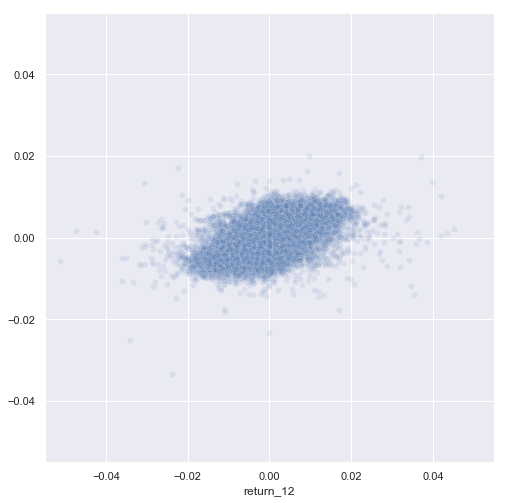

In [59]:
pyplot.axis('scaled')
sns.scatterplot(x = test_data.loc[:, "return_12"], y = prediction, alpha = 0.1)

In [62]:
root_mean_square_error = mean_squared_error(test_data.loc[:, "return_12"], prediction) ** 0.5
root_mean_square_error

0.008353150136261773

Feature ranking:
1. feature return_11 (0.160854)
2. feature return_10_11 (0.073036)
3. feature signal_A_10_11 (0.049865)
4. feature signal_A_11 (0.032698)
5. feature signal_A_9_10 (0.026062)
6. feature return_9_10 (0.023640)
7. feature volatility_6_7 (0.019413)
8. feature signal_A_8_9 (0.018952)
9. feature return_8_9 (0.017607)
10. feature volatility_11 (0.016083)
11. feature volatility_10_11 (0.015906)
12. feature volatility_9_10 (0.015869)
13. feature volatility_5_6 (0.015597)
14. feature return_1_2 (0.014941)
15. feature signal_A_3_4 (0.014769)
16. feature signal_A_7_8 (0.014580)
17. feature return_5_6 (0.014573)
18. feature signal_A_6_7 (0.013845)
19. feature volatility_1_2 (0.013724)
20. feature return_7_8 (0.013233)
21. feature signal_A_1_2 (0.013021)
22. feature return_6_7 (0.012823)
23. feature return_4_5 (0.012728)
24. feature return_0_1 (0.012650)
25. feature return_3_4 (0.012642)
26. feature return_2_3 (0.012124)
27. feature signal_A_5_6 (0.012080)
28. feature signal_A_0_1 (

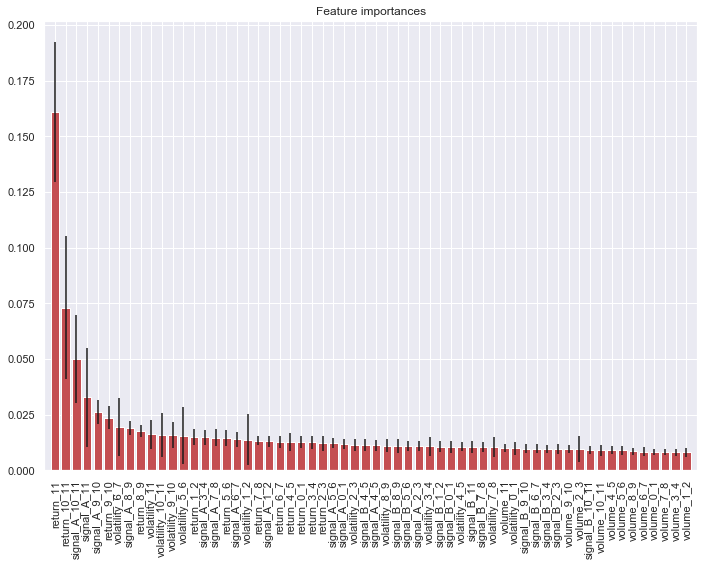

In [89]:
X = test_data.loc[:, test_data.columns != "return_12"]

importances = best_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns.values[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pyplot.xticks(range(X.shape[1]), X.columns.values[indices], rotation= 90)
pyplot.xlim([-1, X.shape[1]])
pyplot.show()

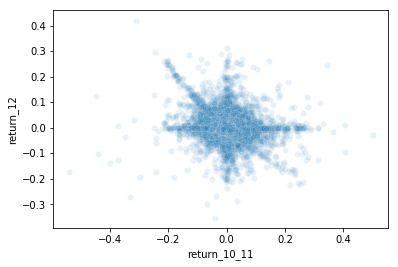

In [62]:
sns.scatterplot(x = "return_10_11", y = "return_12", data = tidy_more_features, alpha = 0.1)

In [235]:
window_size = 12
# The first window is from row 0 to 3, i.e. iloc[0: 0 + window_size - 1]
# The last window is from row len(x.index) - window_size + 1 to len(x.index)
# len(x.index) - window_size + 1 is 
#test.apply(lambda x: x.iloc[i: i + k] for i in range(len(x.index) - k + 1))
#test2 = test.apply(lambda x: x.iloc[i: i + window_size] for i in range(len(x.index) - window_size + 1))
#.apply(lambda x: pd.concat([x.iloc[i: i + k] for i in range(len(x.index) - k + 1)]))])
def make_more(df):
    return [df.iloc[i: i + window_size] for i in range(len(df.index) - window_size + 1)]

#test2 = test.apply(lambda x: make_more(df))